This code is inspired from https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/elasticity.plate.html. More precisely, we copied it, than change some code to fit on our diffusion case. It works well without any problem (in any cases the plot seems good)

In [1]:
pip list

Package           Version
----------------- -----------
asttokens         2.4.1
colorama          0.4.6
comm              0.2.1
contourpy         1.2.0
cycler            0.12.1
debugpy           1.8.1
decorator         5.1.1
DeepXDE           1.11.0
executing         2.0.1
filelock          3.13.1
fonttools         4.49.0
fsspec            2024.2.0
ipykernel         6.29.2
ipython           8.22.1
jedi              0.19.1
Jinja2            3.1.3
joblib            1.3.2
jupyter_client    8.6.0
jupyter_core      5.7.1
kiwisolver        1.4.5
MarkupSafe        2.1.5
matplotlib        3.8.3
matplotlib-inline 0.1.6
mpmath            1.3.0
nest-asyncio      1.6.0
networkx          3.2.1
numpy             1.26.4
packaging         23.2
parso             0.8.3
pillow            10.2.0
pip               23.2.1
platformdirs      4.2.0
prompt-toolkit    3.0.43
psutil            5.9.8
pure-eval         0.2.2
pyaml             23.12.0
Pygments          2.17.2
pyparsing         3.1.1
python-dateutil 


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#TIme dependent example of the presentation
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import torch

In [3]:


# Check if CUDA (GPU) is available and set default tensor type to cuda, but I haven't installed cuda yet
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("/////////////////\n Tensors type on GPU \n///////////////")
else:
  print("/////////////////\n Tensors type on CPU \n///////////////")
# USE_GPU = True
# device = torch.device('cuda') if (USE_GPU and torch.cuda.is_available()) else torch.device('cpu')
# print(device)
  
import deepxde as dde
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/////////////////
 Tensors type on CPU 
///////////////


In [4]:
##Geometry 
sin = torch.sin
cos = torch.cos

end_time = 1
Lx = 1
Ly = 1
geom = dde.geometry.Rectangle([0, 0], [Lx, Ly])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


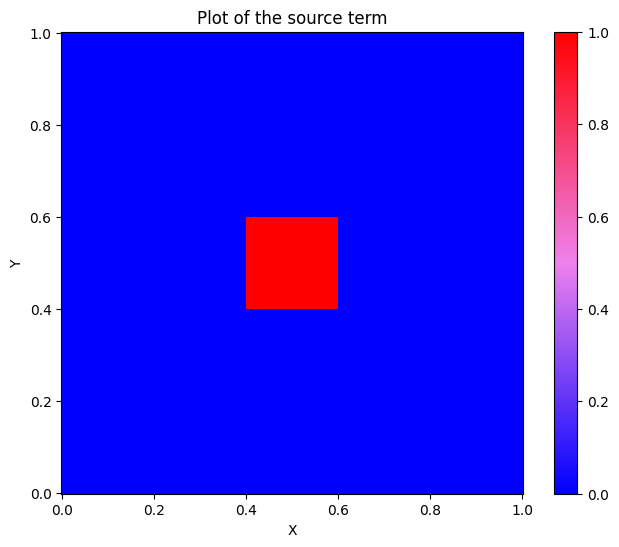

In [5]:
#The definition of the sources and plot of them

#Source places
position_source_1 = torch.tensor([Lx*0.5, Ly*0.5], dtype=torch.float) #float type otherwise it raises an error
position_source_2 = torch.tensor([Lx*0.5, Ly*0.2], dtype=torch.float) #float type otherwise it raises an error


#Some functions to use for the source term
def close_to_source(p, position, width):
    '''position: Position of the middle of the source
        width: width of the source'''
    return (torch.isclose(p[:, 0], position[0], atol=width, rtol=0) * torch.isclose(p[:, 1], position[1], atol=width, rtol=0)).view((-1, 1))


def close_to_source_norm(p, position, width, norm):
    '''position: Position of the middle of the source
        width: width of the source'
        norm: order of the L_q norm. input is np.inf to have the infinite norm.
        (https://pytorch.org/docs/stable/generated/torch.linalg.vector_norm.html#torch.linalg.vector_norm)'''
    

    distance_tensor = torch.linalg.vector_norm(p[:, 0:2] - position, ord=norm, dim=1)
    return torch.isclose(distance_tensor, torch.zeros(1, dtype=torch.float), atol=width, rtol=0).view((-1, 1))




#The source_term
def source_term(p):
    return  close_to_source_norm(p, position_source_1, width=1/10, norm=np.inf)



#Plot of the Source
x = geom.uniform_points(250 * 250, True)
y_norm = source_term(torch.tensor(x))



def plot_routine(plot_values, title):
    resolution_mesh = 250
    xi = np.linspace(0, Lx, resolution_mesh)
    yi = np.linspace(0, Ly, resolution_mesh)
    xi, yi = np.meshgrid(xi, yi)

    zi = griddata(points=(x[:, 0], x[:, 1]), values=plot_values[:, 0], xi=(xi, yi), method="linear")


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "", ["blue", "violet", "red"]
    )
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()


plot_routine(y_norm, "Plot of the source term")


    

In [6]:

def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 1.0)


def boundary_top(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 1.0)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)


def boundary_time(x, on_initial):
    # print(x)
    return on_initial and dde.utils.isclose(x[2], 0.0)




C_top_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_top)
C_bottom_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_bottom)
C_left_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_left)
C_right_bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, boundary_right)
initial_condition = dde.icbc.IC(geomtime, lambda x:0, boundary_time)



In [7]:
def transform_points(p):
    mask = p[:, 1] < 0.5
    result = torch.zeros((p.size(0), 2))
    
    result[mask, 0] = 1
    result[~mask, 0] = -1
    
    return result

p = torch.tensor([[-0.5, 0.3, 0.8],
                  [0.7, 0.6, 0.4]])

output = transform_points(p)
print(output)

tensor([[ 1.,  0.],
        [-1.,  0.]])


In [8]:
#Pde definition and network construction

#Coefficients of the PDE
D= 0.003

u = np.array([1, 0])


def pde(p, C):
    """residual of the pde
    p contains the spatial coordinates x, y and the time t
    the i-th point (xi, yi, ti) is stored in p in the i-th line and we have
    p[i, 0] = xi; p[i, 1] = yi; p[i, 2] = ti
    C corresponds to C(p) the concentration at p"""

    dC_x = dde.grad.jacobian(C, p, j=0)
    dC_y = dde.grad.jacobian(C, p, j=1)
    dC_t = dde.grad.jacobian(C, p, j=2)

    dC_xx = dde.grad.hessian(C, p, i=0, j=0)
    dC_yy = dde.grad.hessian(C, p, i=1, j=1)



 
    return (
        - dC_t
        - u[0] * dC_x
        - u[1] * dC_y
        + D * (dC_xx + dC_yy)  
        + source_term(p)
    )


data = dde.data.TimePDE(
    geomtime,
    pde,
    [C_top_bc,
     C_bottom_bc,
     C_left_bc,
     C_right_bc,
     initial_condition,
    ],
    num_domain=500,
    num_boundary=500,
    num_initial = 200,
    num_test=100,
)

layers = [3] + [40] *3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layers, activation, initializer)

model = dde.Model(data, net)
#Weighted loss: The loss is decomposed into pde, and (bd, ic) losses. The (bd, ic losses) are ordered in the data parameter in an input
#list so it is as the user ordered it (bd_1, ic1, bd_2, ic2) e.g or (bd_1, bd_2, ic_1...)
model.compile("adam", lr=0.001, loss_weights=[0.01, 1, 1, 1, 1, 1])
losshistory, train_state = model.train(epochs=5000)
    
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 0.787994 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.56e-04, 1.20e-02, 1.14e-03, 1.55e-03, 1.10e-02, 8.48e-03]    [6.73e-04, 1.20e-02, 1.14e-03, 1.55e-03, 1.10e-02, 8.48e-03]    []  
1000      [2.32e-04, 1.12e-07, 2.85e-07, 3.14e-07, 2.04e-07, 1.76e-07]    [6.20e-04, 1.12e-07, 2.85e-07, 3.14e-07, 2.04e-07, 1.76e-07]    []  
2000      [2.31e-04, 6.45e-08, 1.51e-07, 1.15e-07, 1.36e-07, 1.74e-07]    [6.20e-04, 6.45e-08, 1.51e-07, 1.15e-07, 1.36e-07, 1.74e-07]    []  
3000      [2.31e-04, 6.33e-08, 1.53e-07, 1.02e-07, 1.68e-07, 2.21e-07]    [6.19e-04, 6.33e-08, 1.54e-07, 1.02e-07, 1.68e-07, 2.21e-07]    []  
4000      [2.31e-04, 7.50e-08, 1.77e-07, 1.06e-07, 2.22e-07, 2.68e-07]    [6.18e-04, 7.50e-08, 1.77e-07, 1.06e-07, 2.22e-07, 2.68e-07]    []  
5000      [2.31e-04, 3.66e-07, 3.25e-07, 1.60e-07, 3.42e-07, 7.23e-07]

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Extracting individual losses
total_losses = losshistory.loss_total
pde_loss = np.array(total_losses)[:, 0]  # First loss is PDE loss
bd_ic_losses = np.array(total_losses)[:, 1:]  # Other losses are for boundary and initial conditions

# Plotting
epochs = np.arange(1, len(total_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, pde_loss, label='PDE Loss')
for i in range(bd_ic_losses.shape[1]):
    plt.plot(epochs, bd_ic_losses[:, i], label=f'Loss {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Individual Losses')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'LossHistory' object has no attribute 'loss_total'

In [12]:
#Plot of the Losses 
    
# Plot the different losses
x = range(len(losshistory))
pde_loss = [item[0] for item in losshistory]
# bd1_loss = [item[1] for item in losshistory]
# ic1_loss = [item[2] for item in losshistory]
# bd2_loss = [item[3] for item in losshistory]
# ic2_loss = [item[4] for item in losshistory]

plt.figure()
plt.plot(x, pde_loss, label='PDE Loss')
# plt.plot(x, bd1_loss, label='Boundary Condition 1 Loss')
# plt.plot(x, ic1_loss, label='Initial Condition 1 Loss')
# plt.plot(x, bd2_loss, label='Boundary Condition 2 Loss')
# plt.plot(x, ic2_loss, label='Initial Condition 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses over Training Epochs')
plt.show()

TypeError: object of type 'LossHistory' has no len()

In [9]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors

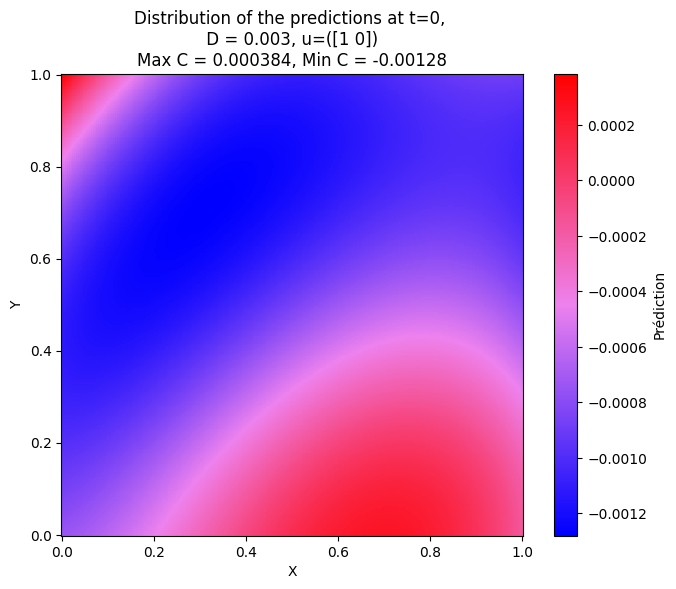

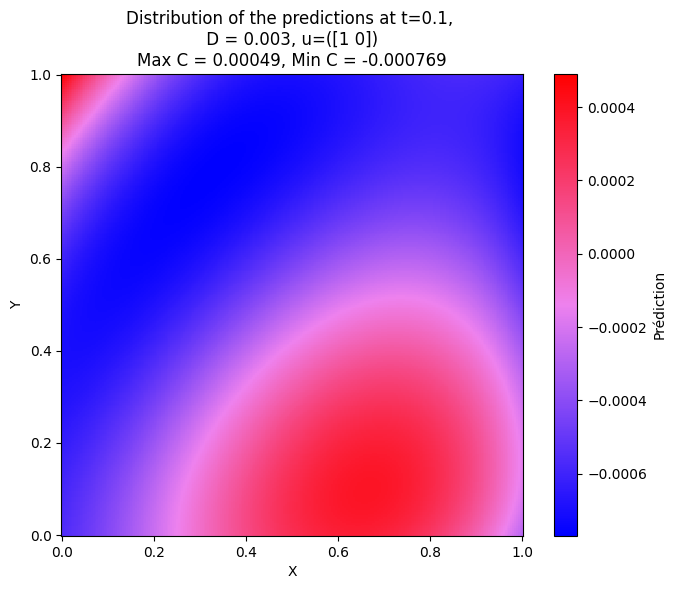

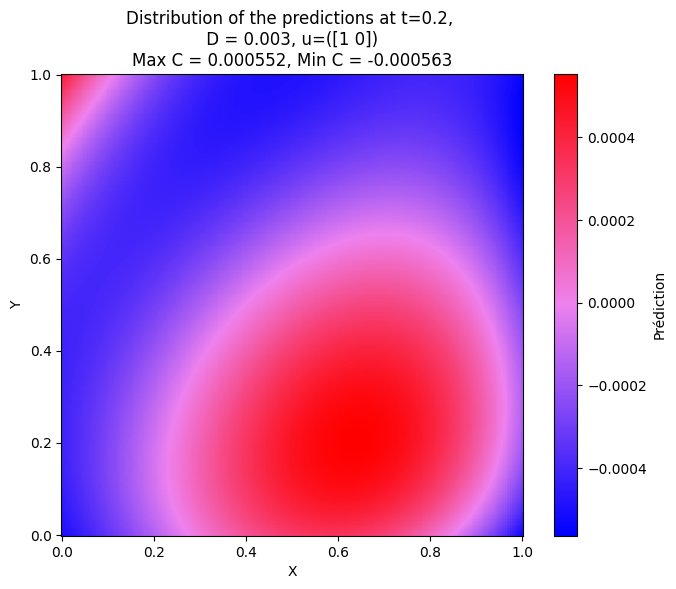

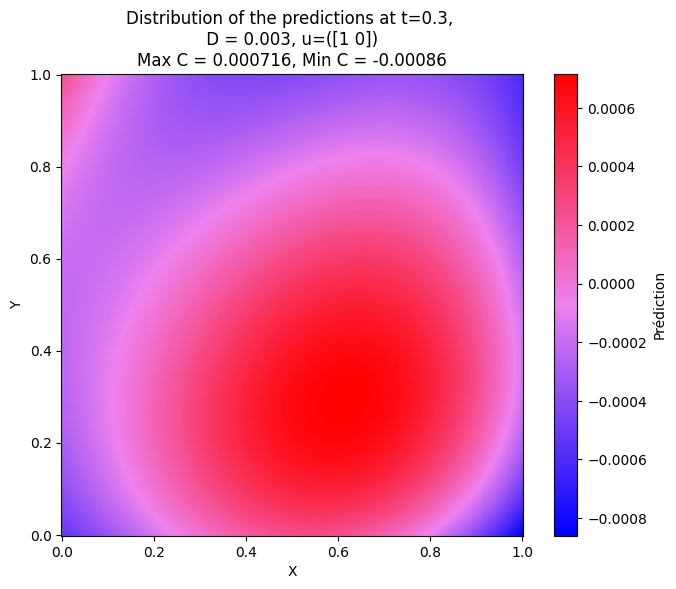

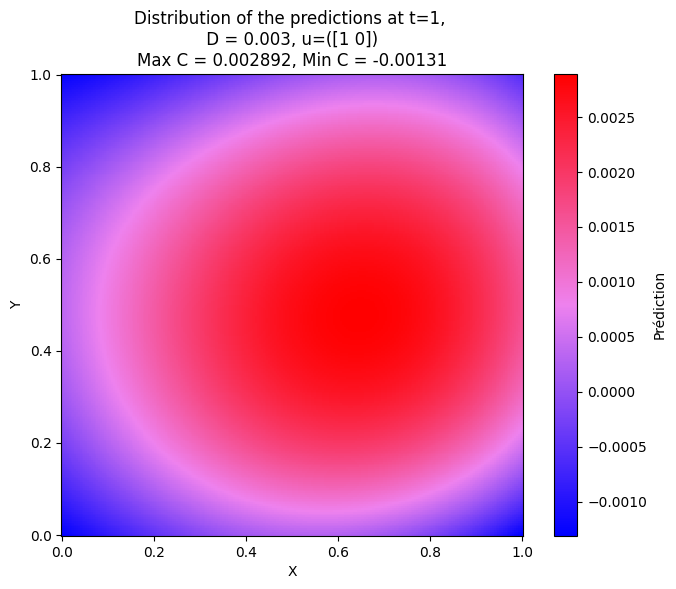

In [10]:
#Code Arnaud
# Test: on affiche le resultat au temps t

time_list = [0, 0.1, 0.2, 0.3, 1]
x = geom.uniform_points(250 * 250, True)
C_max = 0.7 #Max in absolute value to scale the color of the graph
Use_max = False
resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)


for t in time_list:
    p = np.c_[x, np.array([t] * x.shape[0])]
    y = model.predict(p)

    zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

    plt.figure(figsize=(8, 6))
    if Use_max:
        plt.pcolormesh(xi, yi, zi, cmap=cmap, vmin=-1*C_max, vmax=C_max, shading="auto")
    else:
        plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto")
    plt.colorbar(label="Prédiction")
    plt.xlabel("X")
    plt.ylabel("Y")
    title_plot = "Distribution of the predictions " + "at t={time}, \n D = {Diffusion}, u=({advection}) \n" + "Max C = {max}, Min C = {min}"
    plt.title(title_plot.format(time=t, Diffusion = D, advection = u,
                                                         max = int(np.max(y)*10e5)/10e5, min = int(np.min(y)*10e5)/10e5))

    plt.gca().set_aspect('equal', adjustable='box') # Set aspect ratio to have a rectangular plot
    plt.show()
    

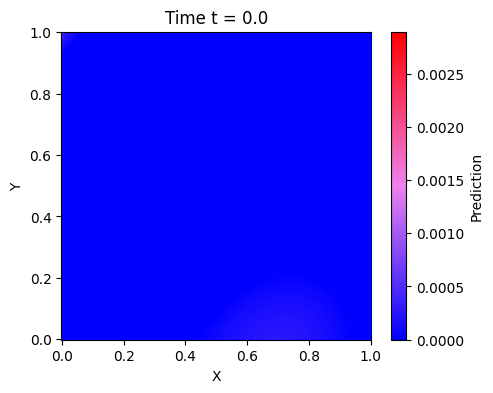

In [11]:
#animation

delta_t = 0.1 # time step for the animation
T_anim = end_time #animation end time
x = geom.uniform_points(250 * 250, True)

resolution_mesh = 250
xi = np.linspace(0, Lx, resolution_mesh)
yi = np.linspace(0, Ly, resolution_mesh)
xi, yi = np.meshgrid(xi, yi)

p = np.c_[x, np.array([end_time] * x.shape[0])]
y = model.predict(p)

C_max = y.max()
zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["blue", "violet", "red"]
)


# Plot for initialization
#plt.ioff()

fig = plt.figure(figsize =(5, 4))
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Time t=0")
quad = plt.pcolormesh(xi, yi, zi, cmap=cmap, shading="auto", vmin=0, vmax=C_max)
#quad = plt.pcolormesh([[]], cmap=cmap, shading='auto')
plt.colorbar(label="Prediction")


def update(frame_id):
    t = delta_t * frame_id

    p = np.c_[x, np.array([t] * x.shape[0])]
    y = model.predict(p)

    zi = griddata((x[:, 0], x[:, 1]), y[:, 0], (xi, yi), method="linear")

    plt.title(f"Time t = {t}")
    #quad.set_clim(zi.min(), zi.max())
    quad.set_array(zi.ravel())

    return quad,


ani = FuncAnimation(fig=fig, func=update, frames=int(T_anim//delta_t)+1, interval=100)

HTML(ani.to_jshtml())

Some remarks on the computation of the solution and the plot:
*  In "y = model.predict(p, operator=pde)", the "operator = pde" part gives weird results so we don't write it. 
*  The plot with constant Concentration scale hides the diffusion when there's a high cocentration variation. 

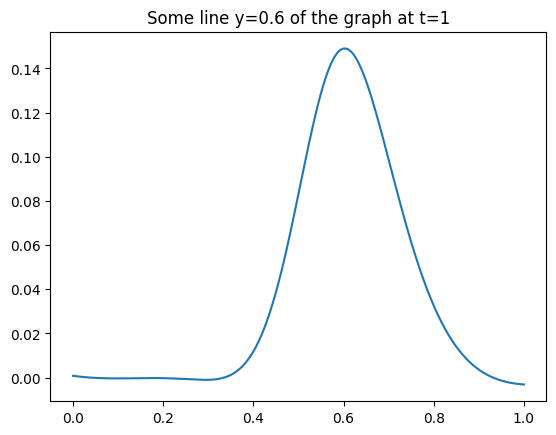

In [16]:
#Verification on some t fixed and y fixed line of the plot

y = 0.6
x = np.linspace(0, 1, 1000)
t = 1

P = np.array([[x, y, t] for x in np.linspace(0, 1, 1000)])
C = model.predict(P)

plt.plot(x, C)
plt.title("Some line y={ordinate} of the graph at t={time}".format(time=t, ordinate = y))
plt.show()
